In [ ]:
import torch # this first torch import is CRUCIAL for finding the libtorch files!
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt

from sph_lib.deposition import (compute_hsm, 
                                compute_hsm_tensor, 
                                project_hsm_tensor_to_2d, 
                                p2g
                                )

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
ds = pn.load('../../data/snapshot_176_128.hdf5')

/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:635: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)


In [4]:
# simulation information
periodic = True
boxsize  = 15000
extent   = np.array([0, boxsize])

# grid information
NN       = 32
gridnum  = 500

In [5]:
# needed fields
pos      = ds.gas['pos']
masses   = ds.gas['mass']
temp     = ds.gas['temp']
metals   = ds.gas['metals'][:, 0]

# IMPORTANT: hsm (tensor) needs to be computed from the 3d distribution (unless the simulation is 2d)!!
hsm = compute_hsm(pos, NN, boxsize)[0]
hmat, eλ, ev = compute_hsm_tensor(pos, masses, NN, boxsize)

# stack all quantities to deposit
quantities = np.stack([masses, metals, temp], axis=-1); print(quantities.shape)

# do we need to average the deposited quantities or not?
averaged   = [False, True, True]

/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:469: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


(2087272, 3)


In [6]:
mask = np.logical_and(pos[:, -1] > 0,
                      pos[:, -1] < 3000)

pos_masked          = pos[mask][:, :2]
masses_masked       = masses[mask]
hsm_masked          = hsm[mask]
hmat_masked        = hmat[mask]
quantities_masked   = quantities[mask]
hmat_2d, eλ_2d, ev_2d = project_hsm_tensor_to_2d(hmat_masked, plane=(0, 1)) 

kwargs = {'positions': pos_masked, 
          'quantities': quantities_masked, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

In [7]:
fields_sph_iso_cpp   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='quintic')

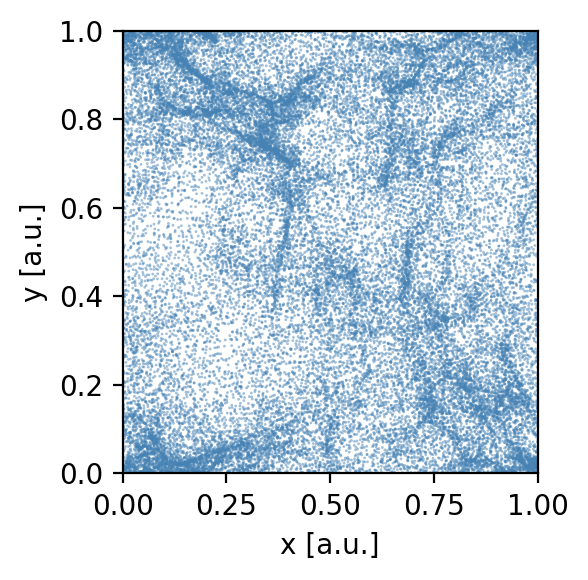

In [32]:
fig, ax = plt.subplots(figsize=(3, 3))

N = 10
ax.scatter(pos_masked[::N, 0] / boxsize, 
           pos_masked[::N, 1] / boxsize, 
           s=1, alpha=0.5, ec='none', color='steelblue')

plt.xlabel(r'x [a.u.]')
plt.ylabel(r'y [a.u.]')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('../plots/overview_particles.pdf')
plt.show()

/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_29246/1588322181.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.imshow(np.rot90(np.log10(fields_sph_iso_cpp[...,0])),


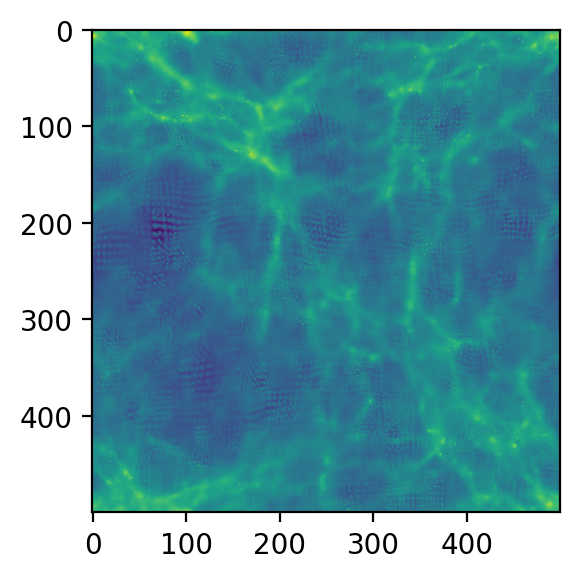

In [31]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.imshow(np.rot90(np.log10(fields_sph_iso_cpp[...,0])), 
          aspect='auto', cmap='viridis')

plt.tight_layout()
plt.savefig('../plots/overview_fields.pdf')
plt.show()